# Faraday verification notebook 

This notebook reads the HDF5 output produced by the C++ executable `test-faraday` and generates diagnostic plots to validate the Faraday operator in 1D.

The executable writes:
- `faraday_test.h5`

Faraday’s law is:
$$
\partial_t \mathbf{B} = -\nabla \times \mathbf{E}.
$$

In 1D (variations only along $x$):
- $\partial_t B_x = 0$
- $\partial_t B_y = +\partial_x E_z$
- $\partial_t B_z = -\partial_x E_y$

In the test we initialize the electric field (on primal nodes):
- $E_y(x) = \sin(x)$
- $E_z(x) = \cos(x)$

so:
- $\partial_x E_z = -\sin(x)$
- $\partial_x E_y = \cos(x)$

and for one explicit step $\Delta t$:
$$
\Delta B_y = B_y^{n+1}-B_y^n = -\Delta t \sin(x),
\qquad
\Delta B_z = B_z^{n+1}-B_z^n = -\Delta t \cos(x).
$$

We will:
1. Load `faraday_test.h5`
2. Plot $\Delta B_y$ and $\Delta B_z$ vs analytic predictions on the **dual** grid
3. Plot pointwise errors and compute max absolute errors (excluding boundary points)

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

H5_PATH = "../../../build-IRT/faraday_test.h5"

with h5py.File(H5_PATH, "r") as f:
    print("Keys in file:", list(f.keys()))

Keys in file: ['By_new', 'By_old', 'Bz_new', 'Bz_old', 'Ey', 'Ez', 'dBy', 'dBz', 'xdual', 'xprimal']


In [3]:
with h5py.File(H5_PATH, "r") as f:
    xprimal = f["xprimal"][:]
    xdual   = f["xdual"][:]
    Ey      = f["Ey"][:]
    Ez      = f["Ez"][:]

    dBy     = f["dBy"][:]
    dBz     = f["dBz"][:]

print("Shapes:")
print(" xdual:", xdual.shape, "dBy:", dBy.shape, "dBz:", dBz.shape)
print(" xprimal:", xprimal.shape, "Ey:", Ey.shape, "Ez:", Ez.shape)

Shapes:
 xdual: (1002,) dBy: (1000,) dBz: (1000,)
 xprimal: (1003,) Ey: (1003,) Ez: (1003,)


### Analytic predictions for $\Delta B_y$ and $\Delta B_z$ (dual grid)

On the dual grid:
$$
\Delta B_y^{\mathrm{exact}}(x) = -\Delta t \sin(x),
\qquad
\Delta B_z^{\mathrm{exact}}(x) = -\Delta t \cos(x).
$$
We set $\Delta t$ to match the value used in the C++ test.


In [7]:
dt = 0.01  # must match test_faraday.cpp

# Align xdual with dBy/dBz length (xdual contains ghost points, dBy/dBz are domain-only)
if len(xdual) == len(dBy) + 2:
    xdual_dom = xdual[1:-1]
else:
    # fallback: truncate to match
    xdual_dom = xdual[:len(dBy)]

dBy_exact = -dt * np.sin(xdual_dom)
dBz_exact = -dt * np.cos(xdual_dom)

# If the implementation sets the last dual domain point as a boundary value, drop it
mask = np.ones_like(xdual_dom, dtype=bool)
mask[-1] = False

max_err_dBy = np.max(np.abs(dBy[mask] - dBy_exact[mask]))
max_err_dBz = np.max(np.abs(dBz[mask] - dBz_exact[mask]))

print("Lengths:")
print(" xdual:", len(xdual), "xdual_dom:", len(xdual_dom), "dBy:", len(dBy))

print("Max |dBy - dBy_exact| (interior) =", max_err_dBy)
print("Max |dBz - dBz_exact| (interior) =", max_err_dBz)


Lengths:
 xdual: 1002 xdual_dom: 1000 dBy: 1000
Max |dBy - dBy_exact| (interior) = 4.1661357340107286e-06
Max |dBz - dBz_exact| (interior) = 4.166145453753101e-06


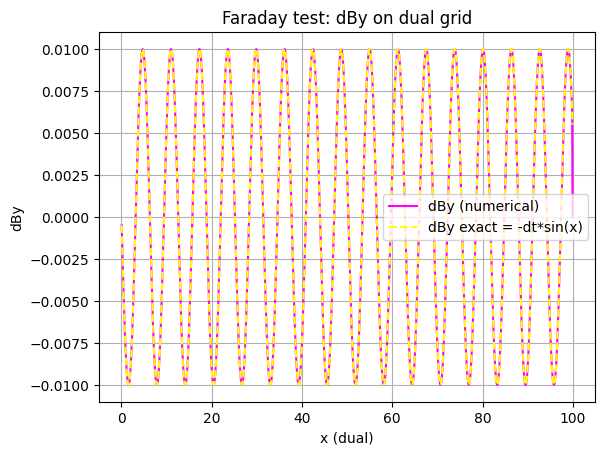

In [14]:
# Plot Delta B_y vs analytic reference (dual grid)

plt.figure()
plt.plot(xdual_dom, dBy, label="dBy (numerical)", color='magenta')
plt.plot(xdual_dom, dBy_exact, "--", label="dBy exact = -dt*sin(x)",color='yellow')
plt.xlabel("x (dual)")
plt.ylabel("dBy")
plt.title("Faraday test: dBy on dual grid")
plt.grid(True)
plt.legend()
plt.savefig("Faraday_dBy.png", dpi=200, bbox_inches="tight")
plt.show()

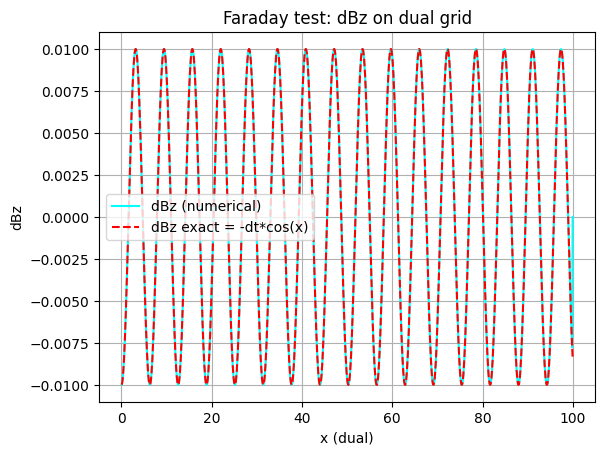

In [18]:
# Plot Delta B_z vs analytic reference (dual grid)
plt.figure()
plt.plot(xdual_dom, dBz, label="dBz (numerical)", color='cyan')
plt.plot(xdual_dom, dBz_exact, "--", label="dBz exact = -dt*cos(x)",color='red')
plt.xlabel("x (dual)")
plt.ylabel("dBz")
plt.title("Faraday test: dBz on dual grid")
plt.grid(True)
plt.legend()
plt.savefig("Faraday_dBz.png", dpi=200, bbox_inches="tight")
plt.show()


### Pointwise error plots (interior points)

We plot the pointwise errors (excluding the last dual point):
$$
e_{By}(x) = \Delta B_y - \Delta B_y^{\mathrm{exact}},
\qquad
e_{Bz}(x) = \Delta B_z - \Delta B_z^{\mathrm{exact}}.
$$


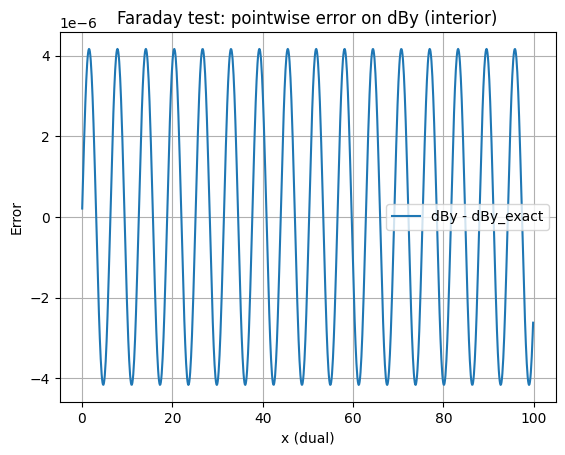

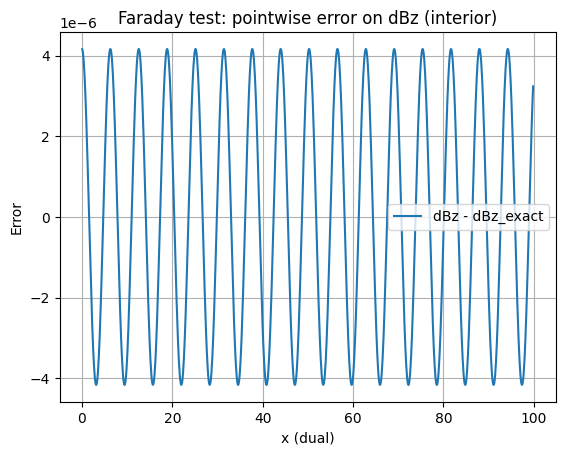

Max abs error dBy (interior): 4.1661357340107286e-06
Max abs error dBz (interior): 4.166145453753101e-06


In [12]:
x_err = xdual_dom[mask]
err_dBy = dBy[mask] - dBy_exact[mask]
err_dBz = dBz[mask] - dBz_exact[mask]

plt.figure()
plt.plot(x_err, err_dBy, label="dBy - dBy_exact")
plt.xlabel("x (dual)")
plt.ylabel("Error")
plt.title("Faraday test: pointwise error on dBy (interior)")
plt.grid(True)
plt.legend()
plt.savefig("Faraday_error_dBy.png", dpi=200, bbox_inches="tight")
plt.show()

plt.figure()
plt.plot(x_err, err_dBz, label="dBz - dBz_exact")
plt.xlabel("x (dual)")
plt.ylabel("Error")
plt.title("Faraday test: pointwise error on dBz (interior)")
plt.grid(True)
plt.legend()
plt.savefig("Faraday_error_dBz.png", dpi=200, bbox_inches="tight")
plt.show()

print("Max abs error dBy (interior):", np.max(np.abs(err_dBy)))
print("Max abs error dBz (interior):", np.max(np.abs(err_dBz)))


- This validates the **curl(E)** update in Faraday’s law in 1D.
- The implementation is first-order in space, so small oscillatory errors are expected.
- The last dual point is treated as a boundary value in the implementation; error metrics focus on interior points.
